# Phase-Aware Steady-State Detection

We wish to find representative regions of simulation and replace those regions with a statistical model to reduce the computational cost of simulation.

This notebook demonstrates two things: 
1. How do we find phases?
2. How do we determine onwhence we have completed any warm-up associated with the phase?

In [1]:
# Built-in modules
import os
import sys
import time
import statistics
from dataclasses import dataclass

# External modules
import scipy
import numpy as np
import pandas as pd
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bokeh.palettes import Pastel1

# Local modules
from Window import Window
from Mapper import Mapper
from Trace  import TraceList

In [2]:
DATA_DIR = 'parrot-traces/medium-100ms-manualpd/'

In [3]:
TRACES = TraceList(DATA_DIR)

In [4]:
print('Directory:'.ljust(10), DATA_DIR)
print('Files:'.ljust(10), TRACES)

Directory: parrot-traces/medium-100ms-manualpd/
Files:     2mm 3mm adi atax bicg cholesky correlation covariance deriche doitgen durbin fdtd-2d floyd-warshall gemm gemver gesummv gramschmidt heat-3d jacobi-1d jacobi-2d lu ludcmp mvt nussinov seidel-2d symm syr2k syrk trisolv trmm


In [5]:
%%time
TRACES.load() # Load the traces into memory. Optional. Skip if all traces can't fit into memory at once

CPU times: user 4min 48s, sys: 42.6 s, total: 5min 31s
Wall time: 5min 31s


In [87]:
@jit
def get_phase_changes(phases):
    pc = []
    for i in range(len(phases)-1):
        if phases[i] != phases[i+1]:
            pc.append(i)
    return pc

def reformat_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(direction='in')
    
@jit
def get_phase_changes(arr, interval_len):
    marker = 0
    #changes = {0:arr[0]}
    intervals = []
    for i in range(len(arr)-1):
        if arr[i] != arr[i+1]:
            intervals.append([marker, i//interval_len, arr[i]])
            marker = i//interval_len
    intervals.append([marker, i//interval_len, arr[-1]])
    return intervals    

def latency_phase_plot(ax, t, interval_len):

    # Get latency data
    df = t.load(persist=True)
    series = df['latency_nano']

    # We will average over intervals. Calculate how many intervals of size interval_len there are
    nintervals = len(series)//interval_len
    peri = [np.mean(series[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]
    
    # Plot
    ax.plot(peri, color='black', markersize=1)
    
    # Add benchmark name
    ax.text(nintervals//2, 15, t.name, ha='center')
    
    # Formatting
    reformat_ax(ax)
    ax.set_xticks([nintervals//2, nintervals])

    
    # Add background patches for each interval
    color = Pastel1[9]
    intervals = get_phase_changes(np.array(df['phase']), interval_len)
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 15, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)

In [95]:
def plot_all(traces, plotter, param, suptitle, filename=None):
    mapper = Mapper(len(traces)) 
    fig = mapper.fig
    accum = {}
    
    for i, t in enumerate(traces):
        accum[t.name] = plotter(mapper[i], t, param)
        
    fig.set_size_inches((5*mapper.smallest_sq, 2*mapper.smallest_sq))
    fig.patch.set_facecolor('white')
    fig.suptitle(suptitle)
    if filename is not None:
        fig.savefig(filename)
    plt.show()
    
    return accum

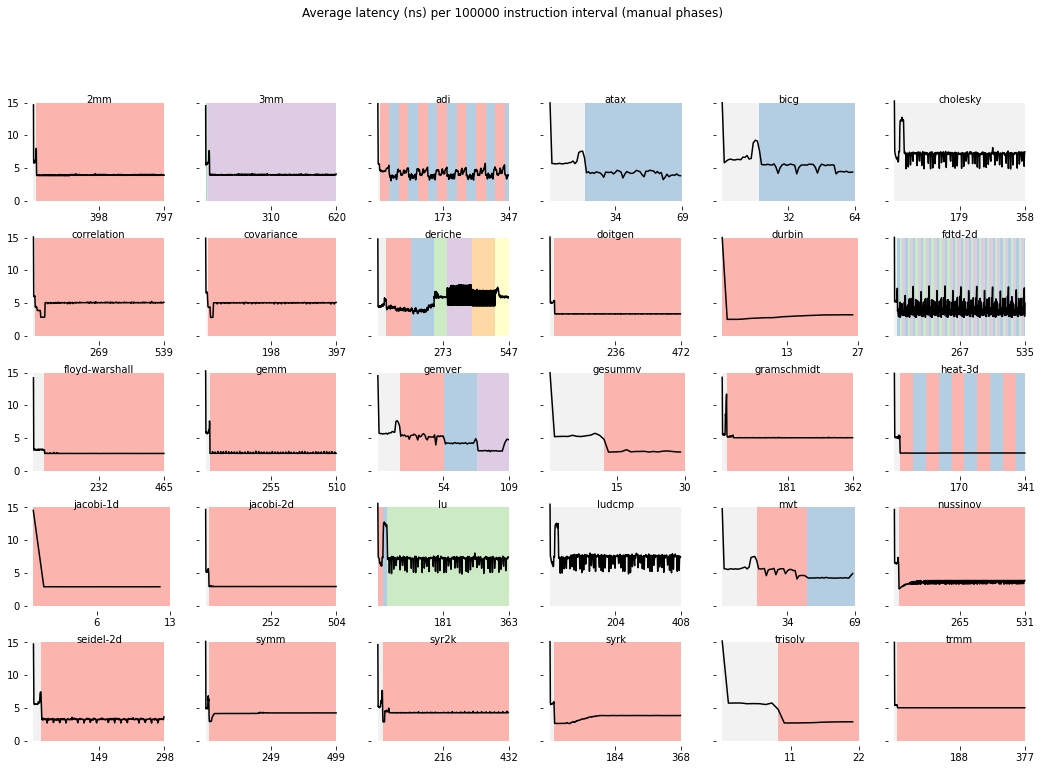

In [76]:
interval_len = 100000
title = f'Average latency (ns) per {interval_len} instruction interval (manual phases)'
plot_all(TRACES, latency_phase_plot, interval_len, title)

In [9]:
%%time
aa = np.array(TRACES[0].load()['phase'])
print(get_phase_changes(aa, interval_len))

[[0, 18, -1], [18, 797, 0]]
CPU times: user 393 ms, sys: 118 ms, total: 511 ms
Wall time: 511 ms


# The F-t-Pj-RG Method

This method was developed by researchers at Virginia Tech and ORNL to detect when Kinetic Monte Carlo simulations had reached a steady state. They want to be able to determine if they have simulated for long enough to end the simulation.

Their method applies three three statistical tests to determine if a steady state has been reached:
- An F-test determines if the variance of two consecutive windows is equal.
- A t-test determines if the mean of two consecutive windows is equal.
- A projection test determines if slope of the data in the windows can predict the data for future intervals

If any one of the tests fails, the windows are "Rolled," meaning they are shifted forwards, and they are "Grown," by a number of datapoints. 

The nice thing about this method is that you get both
1. A time step at which the steady state is a achieved and
1. A region with representative statistics.

## Parameters

The authors state that the most important thing for users to define what a steady state means for their application. This is defined by the projection distance (`proj_dist` in this code, `x_star` in their pseudo-code) and the passing threshold (`proj_delta` here, `delta_y_pass` in their pseudo-code)

In [69]:
# A class for holding all of the parameters needed for the F-t-Pj-RG method
@dataclass(frozen=True)
class FTPJ: 
    # High-level parameters
    window_start:  int = 1000
    summarize:     int = 1000
    ms_init:       int = 10
    debug:         bool = False
    disp_interval: int = 100000
    
    # F-test parameters
    f_conf:  float = 0.05
    f_shift: int = 1
    f_grow:  int = 1
        
    # t-test parameters
    t_conf:  float = 0.05
    t_shift: int = 1
    t_grow:  int = 1
    
    # Projection test parameters
    proj_dist:  int = 5
    proj_delta: float = 1.0
    p_shift:    int = 1
    p_grow:     int = 1
    p_j:        int = 1

In [60]:
def f_test(group1, group2) -> (np.float64, np.float64):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    return f, p_value

In [71]:
def ftPjRG2(df, params, extents = None):
    
    if extents is not None:
        latency = latency = np.array(df.load()['latency_nano'][extents[0]:extents[1]], dtype=np.int64)
    else:
        latency = np.array(df.load()['latency_nano'], dtype=np.int64)
    
    new_len = len(latency) // params.summarize
    latency_summarized = np.array([np.mean(latency[i*params.summarize : (i+1)*params.summarize]) for i in range(new_len)])
    win = Window(latency_summarized, size=params.window_start)
    
    win0 = None
    win1 = None
    ms  = params.ms_init
    _phase = 1
    
    while(True):
        if _phase == 1:
            
            if params.debug:
                print('Phase 1!')
                
            # Update windows
            win0 = win.get(0)
            win1 = win.get(1)
        
            # If we have gone past the end of the input array, then we never reached a steady state
            if win0 is None or win1 is None:
                if params.debug:
                    print('Never converged!')
                return None
        
            # F-test
            # Null hypothesis: windows have same variance
            # Reject null: windows have different variance
            f_val, f_pv = f_test(win0, win1)
            if f_pv < params.f_conf: 
                win.shift_and_grow(params.f_shift, params.f_grow)
                
                if win.size < ms*params.window_start:
                    continue
                else:
                    win.shift_and_reset(params.f_shift, params.window_start)
                    ms = int(ms * g_m)
                    continue
            else:
                _phase = 2
                continue
                

        elif _phase == 2:
            
            if params.debug:
                print('Phase 2!')
                
            # Null: windows have same mean
            # Reject: windows have different mean
            t_val, t_pv = scipy.stats.ttest_ind(win0, win1)
            
            if t_val < params.t_conf:
                win.shift_and_grow(params.t_shift, params.t_grow)
                _phase = 1
                continue
            else:
                _phase = 3
                continue

        elif _phase == 3:
            
            if params.debug:
                print('Phase 3!')
            
            slope_history = []
            for j in range(params.p_j):
                
                win_combo = win.get_range(0+j, 1+j)
                if win_combo is None:
                    if params.debug:
                        print(f'Never converged: unable to perform projection test {j}')
                    return None
            
                lm = LinearRegression()
                lm.fit(np.array(range(len(win_combo))).reshape(-1,1), win_combo.reshape(-1, 1))            
            
                ret = win.get_point(params.proj_dist)
                if ret is None:
                    if params.debug:
                        print('Never converged: Unable to project far enough to confirm projection test.')
                    return None
                x_star, y_true = ret
                y_hat = lm.intercept_ + lm.coef_*x_star
                y_hat = y_hat[0][0]
            
                if np.abs(y_hat - y_true) > params.proj_delta:
                    win.shift_and_grow(params.p_shift, params.p_grow)
                    _phase = 1
                    continue
                    
                slope_history.append(lm.coef_)
            
            if params.p_j > 2:
                pos = np.any(np.array(slope_history) > 0)
                neg = np.any(np.array(slope_history) < 0)
                if pos and neg:
                    return win.start, win.size*2
                else:
                    win.shift_and_grow(params.p_shift, params.p_grow)
                    _phase = 1
                    continue
            
            # Else, params.p_j <= 2
            return win.start, win.size*2
    
        else:
            print(f'Error - phase not recognized {_phase}')
            sys.exit(1)

In [99]:
def ftpjrg_plot_perphase(ax, t, params):
    
    new_len = len(t.load()['latency_nano']) // params.disp_interval
    _ll = t.load()['latency_nano']
    ll = np.array([np.mean(_ll[i*params.disp_interval : (i+1)*params.disp_interval]) for i in range(new_len)])
    ax.plot(ll)
    
    reformat_ax(ax)
    ax.text(new_len//2, 15, t.name, ha='center')
    
    # Phase coloring
    color = Pastel1[9]
    intervals = get_phase_changes(np.array(t.load()['phase']), params.disp_interval)
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 15, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)
        
    # The intervals calculated for phase colors can be used to find the extents of the first
    # execution of each phase. 
    
    stable_regions = {}
    phases_seen = []
    for start, end, phase in intervals:
        if phase in phases_seen or phase == -1:
            continue
        phases_seen.append(phase)
        
        ret = ftPjRG2(t, params, extents=(start*params.disp_interval, end*params.disp_interval))
        if ret is None:
            continue
        stable, stable_size = ret
        
        stable_regions[phase] = (stable*params.summarize, (stable+stable_size)*params.summarize)

        stable = int(stable * (params.summarize / params.disp_interval))
        stable_size = int(stable_size * (params.summarize / params.disp_interval))
                
        ax.axvline(start+stable, color='red')
        ax.axvline(start+stable+stable_size, color='red')
        
    return stable_regions
    

FTPJ(window_start=500, summarize=500, ms_init=10, debug=False, disp_interval=100000, f_conf=0.05, f_shift=1, f_grow=1, t_conf=0.05, t_shift=1, t_grow=1, proj_dist=5, proj_delta=2, p_shift=1, p_grow=1, p_j=4)


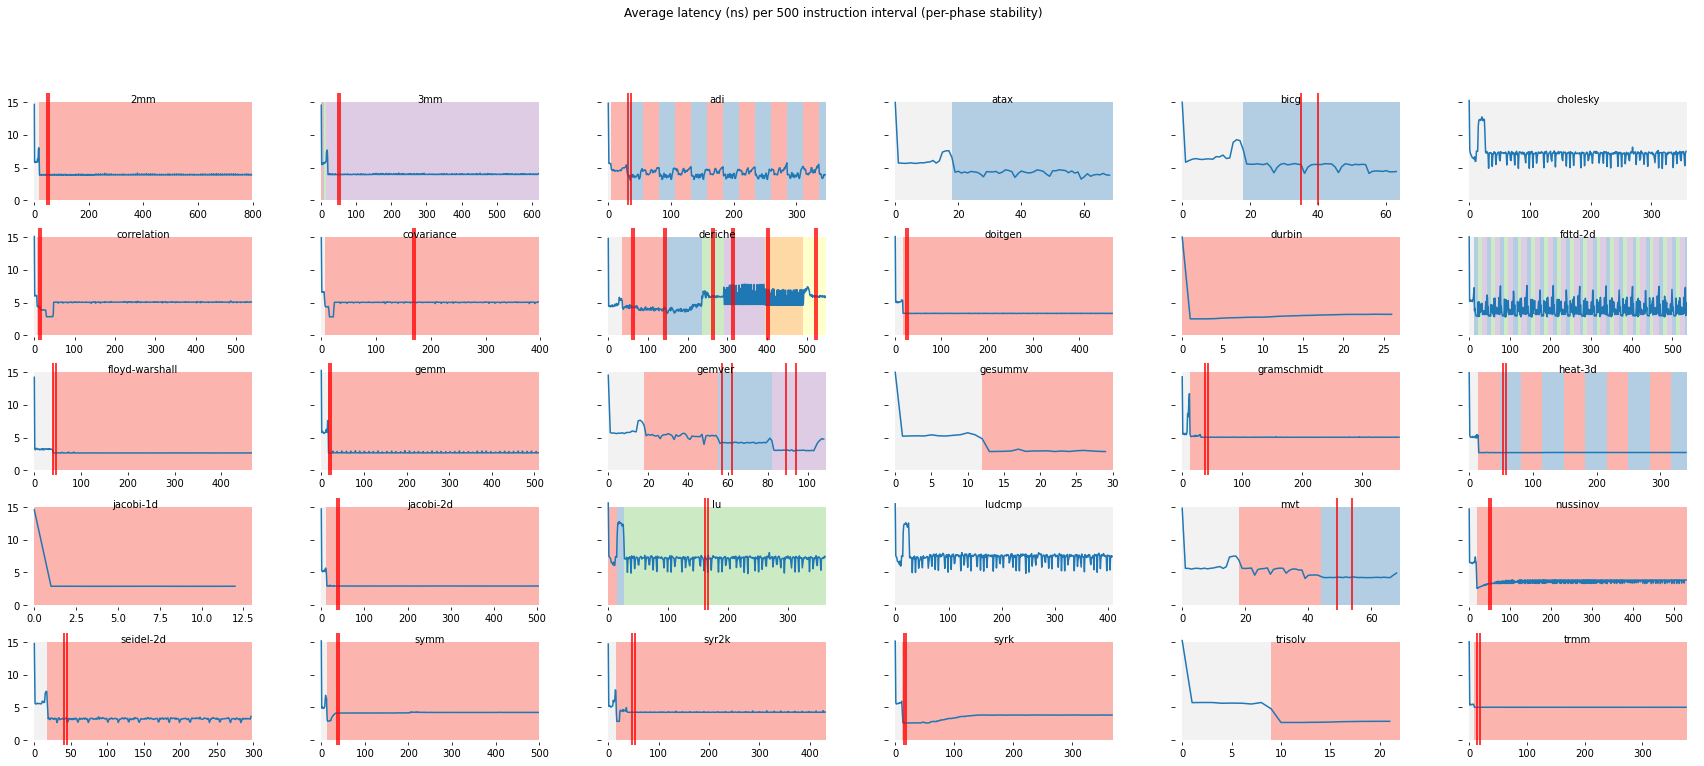

CPU times: user 27.5 s, sys: 8.14 s, total: 35.6 s
Wall time: 29.8 s


In [134]:
%%time
#params = FTPJ(proj_dist=5, window_start=500, summarize=500, p_j=3, proj_delta=1.5)
params = FTPJ(proj_dist=5, window_start=500, summarize=500, p_j=4, proj_delta=2)
print(params)
title = f'Average latency (ns) per {params.summarize} instruction interval (per-phase stability)'
stable_regions = plot_all(TRACES, ftpjrg_plot_perphase, params, title, filename='plots/latency_with_stability.png')

In [108]:
GOOD = ['2mm', 'adi', 'deriche', 'doitgen', 'floyd-warshall', 'gemm', 'gemver', 'gramschmidt', 'head-3d', 'jacobi-2d', 'nussinov', 'seidel-2d', 'symm', 'syr2k', 'syrk', 'trmm']

with open('stable-phases.txt', 'w') as phase_file:
    for name, regions in stable_regions.items():
        if name not in GOOD:
            continue
        for phase_id, stable_range in regions.items():
            phase_file.write(f'{name} {phase_id} {stable_range[0]} {stable_range[1]}\n')

# Next Steps

- [x] In python, combine Phase Detection + FtPjRG
- [ ] Investigate `ludcmp` and `cholesky` missing phases
- [ ] Tune the FtPjRG parameters a bit
- [ ] Once they work a bit better (e.g. fix jacobi-1d), output the representative regions to a file
which can be read by my simulator. (I.e. hard code the representative region boundaries for now.)
- [ ] Evaluation study (below)

## Multifidelity Simulation Plan

1. Phases identified (manually for now)
2. When a new phase is identified, find a representative region using FtPjRG (also going to be manual at first)
3. For the remainder of the phase, sample from the representative region instead of simulating the memory hierarchy

## Evaluation

1. For the polybench benchmarks, determine if this method has an acceptable accuracy for the same system configuration that we collected the data on. 
2. Test other cache parameters
    - The methodology may need to be added to the simulator for it to work with other system configurations
    - For a full-evaluation, we may need to 
3. Try multi-threaded runs
    - The L2 cache will still be shared
    - Note to self: I need to make sure multiple threads don't send the same phase message

# Building the Parrot

- [x] Create region file
- [x] Add "region-file" parameter to Parrot ('file-name.txt:benchmark-name')
- [x] Parse filename and benchmarkname
- [x] Read in data for benchmark from file
- [ ] Subset the workset file (or dont?)
- [x] Sanity check - make sure that the correct phase is executing for each phase specified by the file
- [x] Add a vector to store the representative region (RR)
- [x] Collect the RR
- [x] Implement sampling from the RR
- [ ] Check that everything works for multiple phases
- [ ] more error checking on which pahse we are in
- [ ] Script to compare runtime with and without Parroting (make sure tracing is disabled - probably add this comnand line option too)
- [ ] IMPORTANT: fix time conversion on selfLink->send
- [ ] Create struct in Parrot.h to hold on to phase information. Then we only need one map. Also make sure the default value for the map is the -1 phase, or create a special placeholder in the map for the -1 phase
- [ ] Try linear access instead of random lol
- [ ] Add IPC output? Or find where you left it


In [130]:
np.max(np.array(TRACES.traces[5].data['phase']))

-1